In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from dateutil import parser
from dateutil.relativedelta import relativedelta
from collections import Counter
import math
from shapely.vectorized import contains

# Open and Pre-process

In [3]:
data_location = 'data'
# outlooks, pph, reports = read_datasets(data_location)
outlook1 = gp.read_file(f"{data_location}/outlooks/all_outlooks_1.shp", engine="pyogrio")
outlook2 = gp.read_file(f"{data_location}/outlooks/all_outlooks_2.shp", engine="pyogrio")
outlooks = gp.GeoDataFrame(pd.concat([outlook1, outlook2], ignore_index=True), crs=outlook1.crs)
pph = xr.open_dataset(data_location + '/pph/all_pph.nc')

In [4]:
tz_conversions = {'PST': timedelta(hours=8),
                  'MST': timedelta(hours=7),
                  'CST': timedelta(hours=6),
                  'CSt': timedelta(hours=6),
                  'CSC': timedelta(hours=6),
                  'SCT': timedelta(hours=6),
                  'EST': timedelta(hours=5),
                  'ESt': timedelta(hours=5),
                  'PDT': timedelta(hours=7),
                  'MDT': timedelta(hours=6),
                  'CDT': timedelta(hours=5),
                  'EDT': timedelta(hours=4),
                  'HST': timedelta(hours=10),
                  'SST': timedelta(hours=11),
                  'GST': timedelta(hours=10),
                  'AKS': timedelta(hours=9),
                  'AST': timedelta(hours=4),
                  'UNK': timedelta(hours=5),
                  'GMT': timedelta(0)}

def get_reports_date_strings(date_times, timezones):
    # returns list of strings of date of given datetime and timezone (where day cutoffs are 12-12 UTC) formatted as 'YYYYMMDD0000'
    for datetime, timezone, i in zip(date_times, timezones, range(len(timezones))):
        #print(datetime + ' ' + timezone[:3])
        datetime = parser.parse(datetime)
        datetime = datetime + tz_conversions[timezone[:3]]
        #print(datetime)
        if (datetime.hour < 12):
            datetime = datetime - timedelta(days = 1)
        if datetime.year > 2049:
            datetime = datetime - relativedelta(years = 100)
        datetime = datetime.strftime("%Y%m%d") + '0000'
        if i == 0:
            ret = [datetime]
        else:
            ret.append(datetime)
    return ret

def get_pph_date_strings(times):
    # returns a list of strings of given dates formatted as 'YYYYMMDD0000'
    for datetime, i in zip(times, range(len(times))):
        string = datetime.dt.strftime("%Y%m%d").values + '0000'
        if i == 0:
            ret = [string]
        else:
            ret.append(string)
    return ret

In [5]:
#reports['DATE'] = get_reports_date_strings(reports['BEGIN_DATE_TIME'], reports['CZ_TIMEZONE']) 
pph['time'] = get_pph_date_strings(pph.time) 
# subset outlooks into only one day 1, two day 2, and one day 3 categorical outlooks 
# day 3: cycle not -1. day 2: cycle not -1. Day 1: cycle 6. Category: categorical. 
#outlooks = outlooks[(((outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6)) | ((outlooks['DAY'] == 2) & (outlooks['CYCLE'] != -1)) | ((outlooks['DAY'] == 3) & (outlooks['CYCLE'] != -1)))
#        & (outlooks['CATEGORY'] == 'CATEGORICAL')]

# reset incicies
outlooks = outlooks.reset_index(drop=True)
#reports = reports.drop(columns=['geometry'])

In [6]:
outlooks

,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,DATE,geometry
0,198701011200,198701021200,198701010635,C,1,TSTM,CATEGORICAL,6,198701010000,"MULTIPOLYGON (((-80.69500 29.36500, -80.68200 ..."
1,198701011500,198701021200,198701011441,C,1,TSTM,CATEGORICAL,-1,198701010000,"POLYGON ((-70.15100 42.90900, -70.14600 42.899..."
2,198701011900,198701021200,198701011849,C,1,TSTM,CATEGORICAL,-1,198701010000,"POLYGON ((-73.73200 39.90700, -73.73200 39.892..."
3,198701021200,198701031200,198701020637,C,1,TSTM,CATEGORICAL,6,198701020000,"POLYGON ((-124.43300 41.91800, -124.44100 41.9..."
4,198701031200,198701041200,198701020725,C,2,None,None,7,198701030000,None
...,...,...,...,...,...,...,...,...,...,...
366365,202401021200,202401031200,202312310815,C,3,TSTM,CATEGORICAL,8,202401020000,"POLYGON ((-90.74500 28.71100, -91.08300 28.732..."
366366,202312311300,202401011200,202312311236,C,1,None,None,13,202312310000,None
366367,202312311630,202401011200,202312311558,C,1,None,None,16,202312310000,None
366368,202401011200,202401021200,202312311712,C,2,None,None,17,202401010000,None


In [7]:
# old_outlook_dataset = xr.open_dataset('data/outlooks/grid_outlooks.nc')

# Gridize outlooks

In [8]:
def get_outlooks_subset(outlooks, outlook_type):
    outlooks = outlooks[(outlooks['THRESHOLD'] != 'SIGN') & (outlooks['THRESHOLD'] != 'TSTM')]
    if outlook_type == 'Day 3':
        return outlooks[(outlooks['DAY'] == 3) & (outlooks['CYCLE'] != -1) & (outlooks['CATEGORY'] == 'ANY SEVERE')]
    elif outlook_type == 'Day 2 7':
        return outlooks[(outlooks['DAY'] == 2) & (outlooks['CYCLE'] == 7) & (outlooks['CATEGORY'] == 'ANY SEVERE')]
    elif outlook_type == 'Day 2 17':
        return outlooks[(outlooks['DAY'] == 2) & (outlooks['CYCLE'] == 17) & (outlooks['CATEGORY'] == 'ANY SEVERE')]
    elif outlook_type == 'Day 1':
        return outlooks[(outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6) & (outlooks['CATEGORY'] == 'ANY SEVERE')]
    elif outlook_type == 'Day 1 Wind':
        return outlooks[(outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6) & (outlooks['CATEGORY'] == 'WIND')]
    elif outlook_type == 'Day 1 Hail':
        return outlooks[(outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6) & (outlooks['CATEGORY'] == 'HAIL')]
    elif outlook_type == 'Day 1 Tornado':
        return outlooks[(outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6) & (outlooks['CATEGORY'] == 'TORNADO')]
    
    elif outlook_type == 'Day 2 7 Wind':
        return outlooks[(outlooks['DAY'] == 2) & (outlooks['CYCLE'] == 7) & (outlooks['CATEGORY'] == 'WIND')]
    elif outlook_type == 'Day 2 17 Wind':
        return outlooks[(outlooks['DAY'] == 2) & (outlooks['CYCLE'] == 17) & (outlooks['CATEGORY'] == 'WIND')]
    elif outlook_type == 'Day 2 7 Hail':
        return outlooks[(outlooks['DAY'] == 2) & (outlooks['CYCLE'] == 7) & (outlooks['CATEGORY'] == 'HAIL')]
    elif outlook_type == 'Day 2 17 Hail':
        return outlooks[(outlooks['DAY'] == 2) & (outlooks['CYCLE'] == 17) & (outlooks['CATEGORY'] == 'HAIL')]
    elif outlook_type == 'Day 2 7 Tornado':
        return outlooks[(outlooks['DAY'] == 2) & (outlooks['CYCLE'] == 7) & (outlooks['CATEGORY'] == 'TORNADO')]
    elif outlook_type == 'Day 2 17 Tornado':
        return outlooks[(outlooks['DAY'] == 2) & (outlooks['CYCLE'] == 17) & (outlooks['CATEGORY'] == 'TORNADO')]
    
    raise Exception("Invalid outlook_type given to get_outlooks_subset")

In [9]:
# as in mca: create_gridded_outlook_dataset. But will need to work overall, not just by hazard. day 3 is overall probability, days 1 and 2 by hazard
# day 3 use ANY SEVERE, day 2 use ANY SEVERE, day 1 construct from each hazard (assuming independence? or use highest prob, which basically assumes complete dependence? Is this what is done for day 2?)
# Things are entirely categorical before 2002, so even more reason to make that the cutoff.

outlook_types = ['Day 3', 'Day 2 7', 'Day 2 17', 
                 'Day 2 7 Wind', 'Day 2 7 Hail', 'Day 2 7 Tornado', 
                 'Day 2 17 Wind', 'Day 2 17 Hail', 'Day 2 17 Tornado',
                 'Day 1 Wind', 'Day 1 Hail', 'Day 1 Tornado', 
                 'Day 1']

outlook_dataset = xr.Dataset(
    data_vars=dict(
        lat=(['y', 'x'], pph['lat'].data),
        lon=(['y', 'x'], pph['lon'].data)
    ),
    coords=dict(
        time=(['time'], pph['time'].data),
        x=(['x'], pph['x'].data),
        y=(['y'], pph['y'].data),
        outlook=(['outlook'], outlook_types)
    ),
    attrs=dict(description="outlook as a percentage as a function of date, lat/lon, and which hazard type",
            grid = pph.grid),
)

outlook_dataset = outlook_dataset.assign(prob = (('time', 'y', 'x', 'outlook'), np.full((len(outlook_dataset['time']), len(outlook_dataset['y']), len(outlook_dataset['x']), len(outlook_types)), 0.0)))





In [10]:
# adding an additional year
#outlook_dataset = old_outlook_dataset.reindex(time=pph['time'], fill_value=0)
#del old_outlook_dataset
#outlook_dataset
# just full of zeros in new year, fill below

In [11]:
todo_times = outlook_dataset['time']#[outlook_dataset['time'].str.startswith('2023')]

In [12]:
save_location = 'data/outlooks/grid_outlooks.nc'

In [14]:
def rasterize_polygons(polygons, thresholds, lat_grid, lon_grid):
    result = np.zeros(lat_grid.shape)
    for poly, thresh in zip(polygons, thresholds):
        mask = contains(poly, lon_grid, lat_grid)
        result[mask & (result == 0)] = thresh  # only fill unassigned cells
    return result

# Extract static lat/lon once
lat_grid = outlook_dataset.lat.values  # shape (y, x)
lon_grid = outlook_dataset.lon.values

# Loop over each outlook type
for outlook_type in outlook_types:
    print(outlook_type)
    outlooks_subset = get_outlooks_subset(outlooks, outlook_type)
    grouped_outlooks = dict(tuple(outlooks_subset.groupby('DATE')))

    array = np.zeros((len(todo_times), lat_grid.shape[0], lat_grid.shape[1]))

    oldyear = None
    for i, date in enumerate(todo_times.values):
        #year = date[:4]
        #if year != oldyear:
        #    print(year)
        #    oldyear = year

        outlooks_date = grouped_outlooks.get(date)
        if outlooks_date is not None and len(outlooks_date) > 0:
            outlooks_date = outlooks_date.sort_values(by='THRESHOLD', ascending=False)
            polygons = outlooks_date['geometry'].tolist()
            thresholds = outlooks_date['THRESHOLD'].tolist()

            array[i] = rasterize_polygons(polygons, thresholds, lat_grid, lon_grid)

    # Convert to DataArray and assign into dataset
    me = xr.DataArray(array, coords={
        'time': todo_times,
        'y': outlook_dataset.y.values,
        'x': outlook_dataset.x.values
    }, dims=['time', 'y', 'x'])

    outlook_dataset['prob'].loc[dict(outlook=outlook_type, time=todo_times)] = me

    # Save after each outlook type (optional)
    outlook_dataset.to_netcdf(save_location)

Day 3
Day 2 7
Day 2 17
Day 2 7 Wind
Day 2 7 Hail
Day 2 7 Tornado
Day 2 17 Wind
Day 2 17 Hail
Day 2 17 Tornado
Day 1 Wind
Day 1 Hail
Day 1 Tornado
Day 1


In [ ]:
outlook_dataset.to_netcdf('data/outlooks/grid_outlooks.nc')

In [ ]:
outlook_dataset['prob'].mean()

In [ ]:
outlook_dataset = xr.open_dataset(save_location)
outlook_dataset

In [ ]:
outlook_dataset.sel(outlook = 'Day 1', time = '202304060000').prob.max(dim = ['x', 'y'])

<xarray.DataArray 'prob' ()>
array(0.15)
Coordinates:
    time     <U12 '202304060000'
    outlook  <U16 'Day 1'

: 

In [20]:
# build day 1 and Feb 1 2020- day 2 probabilities: max (assuming total dependence) seems right, set to True
dependent = True

for outlook in ['Day 1', 'Day 2 7', 'Day 2 17']:
    print(outlook)
    year = ''
    for time in outlook_dataset['time']:
        time = str(time.values)
        newyear = time[0:4]
        if newyear != year:
            print(newyear)
            year = newyear
        if dependent:
            m = outlook_dataset['prob'].sel(time = time, outlook = [outlook + ' Wind', outlook + ' Hail', outlook + ' Tornado']).max(dim = 'outlook')
            
        else:
            m = (1-(1-outlook_dataset['prob'].sel(time = time, outlook = [outlook + ' Wind'])).data * (1-outlook_dataset['prob'].sel(time = time, outlook = [outlook + ' Hail'])).data * (1-outlook_dataset['prob'].sel(time = time, outlook = [outlook + ' Tornado'])).data)[:, :, 0]
        if m.values.max() > 0:
            outlook_dataset['prob'].loc[dict(time = time, outlook = outlook)] = m

Day 1
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
Day 2 7
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
Day 2 17
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [21]:
outlook_dataset.to_netcdf('data/outlooks/grid_outlooks.nc')

# Plot

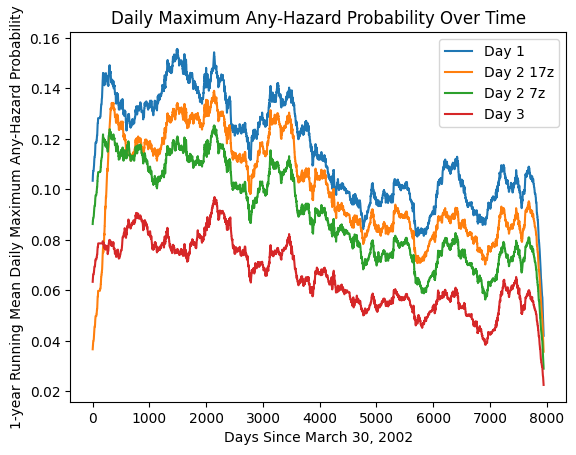

In [22]:
# check that max was a reasonable way to combine hazard probabilities
plt.plot(np.convolve(outlook_dataset['prob'].sel(outlook = 'Day 1').max(dim=['x', 'y']).data[8489:], np.ones(365)/365, 'same'))
plt.plot(np.convolve(outlook_dataset['prob'].sel(outlook = 'Day 2 17').max(dim=['x', 'y']).data[8489:], np.ones(365)/365, 'same'))
plt.plot(np.convolve(outlook_dataset['prob'].sel(outlook = 'Day 2 7').max(dim=['x', 'y']).data[8489:], np.ones(365)/365, 'same'))
plt.plot(np.convolve(outlook_dataset['prob'].sel(outlook = 'Day 3').max(dim=['x', 'y']).data[8489:], np.ones(365)/365, 'same'))
plt.legend(['Day 1', 'Day 2 17z', 'Day 2 7z', 'Day 3'])
if dependent:
    plt.title('Daily Maximum Any-Hazard Probability Over Time')
else:
    plt.title('Daily Maximum Any-Hazard Probability Over Time (assuming independent hazards)')
plt.ylabel('1-year Running Mean Daily Maximum Any-Hazard Probability')
plt.xlabel('Days Since March 30, 2002')
if dependent:
    plt.savefig('plots/prob_over_time.png')
else:
    plt.savefig('plots/prob_over_time_indep.png')


# This is kind of an interesting result on its own. Forecast practices have changed... higher risks issued less liberally